<a href="https://colab.research.google.com/github/nickwan/rl_scouting_reports/blob/main/rocket_league.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# rocket league ds 
i'm plat in game but gc in data science  

not the cleanest code amirite? 

# load in 

In [1]:
!pip install shap --quiet
!apt-get update
!apt install imagemagick

     |████████████████████████████████| 358kB 7.5MB/s 
Get:1 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:2 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:3 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:4 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:6 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:8 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:12 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:13 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Hit:14 http://ppa.launchpad.net/g

In [1]:
import warnings
from tqdm import tqdm_notebook
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import lightgbm as lgb
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import accuracy_score, log_loss, mean_squared_error, confusion_matrix
import itertools
import random
import shap
import os
import gzip
import matplotlib.animation as animation
from matplotlib import rc

import codecs
decode_hex = codecs.getdecoder("hex_codec")

rc('animation', html='html5')
sns.set_context('talk')


In [14]:
def load_rl_replay(rl_replay_file):
  _json = carball.decompile_replay(rl_replay_file)

  game = Game()
  game.initialize(loaded_json=_json)
  analysis_manager = AnalysisManager(game)
  analysis_manager.create_analysis()

  # write proto out to a file
  # read api/*.proto for info on the object properties
  with open(os.path.join('output.pts'), 'wb') as fo:
      analysis_manager.write_proto_out_to_file(fo)
      
  # write pandas dataframe out as a gzipped numpy array
  with gzip.open(os.path.join('output.gzip'), 'wb') as fo:
      analysis_manager.write_pandas_out_to_file(fo)
      
  # return the proto object in python
  proto_object = analysis_manager.get_protobuf_data()

  # return the pandas data frame in python
  dataframe = analysis_manager.get_data_frame()
  return dataframe, game, proto_object

def get_df_players(game):
  df_players = pd.DataFrame()
  for x in game.players:
    df_players = (df_players
                  .append(pd.DataFrame([[int(x.online_id),x.name,x.team.name,x.is_orange]],
                                      columns=['id','name','team','is_orange']),
                          ignore_index=True))
  return df_players  

def get_game_info(game):
  warnings.filterwarnings("ignore")
  df_players = get_df_players(game)
  game_info = pd.DataFrame([[format(game.datetime,"%Y%m%d%H%M%S"),game.game_info.match_guid,int(game.name[4]),game.id]],columns=['match_date','match_id','game_number','game_id'])
  game_info = pd.concat([game_info,df_players],axis=1)
  game_info = game_info.fillna(method='ffill')
  return game_info  

def get_df_game(dataframe,game_info):
  warnings.filterwarnings("ignore")
  game_info_cols = ['match_date', 'match_id', 'game_number', 'game_id']
  _game_info = game_info.loc[[1],game_info_cols].drop_duplicates()

  df_game = dataframe['game']
  df_game['goal_number'] = df_game['goal_number'].fillna(-np.inf)
  df_game['seconds'] = df_game['seconds_remaining'].sub(300).abs()
  df_game = pd.concat([_game_info,df_game],axis=1)
  df_game = df_game.reset_index().rename(columns={'index':'frames'})
  df_game.loc[:,game_info_cols] = df_game.loc[:,game_info_cols].fillna(method='ffill')
  return df_game 

def get_df_hits(proto_object,game):
  name_map = {player.name: int(player.online_id) for player in game.players}
  _id2name = pd.DataFrame.from_dict([name_map]).T.reset_index().rename(columns={'index':'player_name',0:'player_id'})
  hits = proto_object.game_stats.hits
  df_hits = pd.DataFrame()
  for hit in hits:
    _df = pd.DataFrame([[proto_object.game_metadata.match_guid,proto_object.game_metadata.id,hit.goal,hit.frame_number,int(hit.player_id.id),hit.collision_distance,hit.ball_data.pos_x,hit.ball_data.pos_y,hit.ball_data.pos_z,hit.distance,hit.distance_to_goal,hit.next_hit_frame_number,hit.goal_number,hit.is_kickoff]],columns=['match_id','game_id','goal','frame_number','player_id','collision_distance','pos_x','pos_y','pos_z','distance','distance_to_goal','next_hit_frame_number','goal_number','is_kickoff'])
    df_hits = df_hits.append(_df,ignore_index=True)
  df_hits = df_hits.merge(_id2name)
  return df_hits

def flatten_dataframe(dataframe,game_info):
  warnings.filterwarnings("ignore")
  game_info_cols = ['match_date','match_id','game_number','game_id','id','name','team','is_orange']
  to_melt = [x for x in dataframe.columns.levels[0].values if x not in ['ball', 'game']]

  flat_df = pd.DataFrame()
  for player_name in to_melt:
    _df = dataframe[player_name]
    _df = _df.reset_index().rename(columns={'index':'frames'})
    column_list = _df.columns.values
    column_list = game_info_cols+column_list.tolist()
    _df = pd.concat([game_info.loc[game_info['name']==player_name],_df],axis=1)
    _df.loc[:,game_info_cols] = _df.loc[:,game_info_cols].fillna(method='bfill').fillna(method='ffill')
    flat_df = flat_df.append(_df,ignore_index=True)
  flat_df = flat_df.loc[:,column_list]  
  flat_df = generate_zones(flat_df)
  return flat_df

def generate_zones(df):
  zone_markers = {'x': 1100.0, 'y': 1750.0}
  for col in ['x', 'y', 'z']:
    df[f'{col}_zone'] = 0


  df.loc[df['pos_x']<-zone_markers['x'],'x_zone'] = -1
  df.loc[df['pos_x'].between(-zone_markers['x'],zone_markers['x']),'x_zone'] = 0
  df.loc[df['pos_x']>zone_markers['x'],'x_zone'] = 1

  df.loc[df['pos_y']<-zone_markers['y'],'y_zone'] = -1
  df.loc[df['pos_y'].between(-zone_markers['y'],zone_markers['y']),'y_zone'] = 0
  df.loc[df['pos_y']>zone_markers['y'],'y_zone'] = 1

  df.loc[df['pos_z']<500,'z_zone'] = 0
  df.loc[df['pos_z'].between(500,1500),'z_zone'] = 1
  df.loc[df['pos_z']>1500,'z_zone'] = 2 
  return df  

def get_df_ball(dataframe,game_info):
  warnings.filterwarnings("ignore")
  game_info_cols = ['match_date', 'match_id', 'game_number', 'game_id']
  _game_info = game_info.loc[[1],game_info_cols].drop_duplicates()
  df_ball = dataframe['ball']  
  df_ball = generate_zones(df_ball)  
  df_ball = pd.concat([_game_info,df_ball],axis=1)
  df_ball = df_ball.reset_index().rename(columns={'index':'frames'})
  df_ball.loc[:,game_info_cols] = df_ball.loc[:,game_info_cols].fillna(method='ffill')
  return df_ball

def get_df_goals(game,game_info):
  warnings.filterwarnings("ignore")
  game_info_cols = ['match_date', 'match_id', 'game_number', 'game_id']
  _game_info = game_info.loc[[1],game_info_cols].drop_duplicates()
  df_goals = pd.DataFrame()
  for idx_goal in range(len(game.goals)):
    goal = game.goals[idx_goal]
    df_goal = pd.DataFrame([[int(goal.player.online_id),goal.player.name,bool(goal.player_team),goal.frame_number]], columns=['id','name','is_orange','goal_frame_number'])
    df_goals = df_goals.append(df_goal,ignore_index=True)
    df_goals = df_goals.sort_values('goal_frame_number').reset_index(drop=True)
  df_goals = pd.concat([_game_info,df_goals],axis=1)
  df_goals.loc[:,game_info_cols] = df_goals.loc[:,game_info_cols].fillna(method='ffill').fillna(method='bfill')
  return df_goals    

def plot_gridlines(view='xy'):
  if view=='xy':
    plt.axvline(-4000,c='k')
    plt.axvline(4000,c='k')    
    plt.axvline(1333,c='r',ls=':')
    plt.axvline(-1333,c='r',ls=':')

    plt.axhline(-6000,c='k')
    plt.axhline(6000,c='k')
    plt.axhline(-2000,c='r',ls=':')
    plt.axhline(2000,c='r',ls=':')

  elif view=='xz':
    plt.axvline(-4000,c='k')
    plt.axvline(4000,c='k')    
    plt.axvline(1333,c='r',ls=':')
    plt.axvline(-1333,c='r',ls=':')

    plt.axhline(0,c='k')
    plt.axhline(2000,c='k')
    plt.axhline(500,c='r',ls=':')
    plt.axhline(1500,c='r',ls=':')

  elif view=='yz':
    plt.axvline(-6000,c='k')
    plt.axvline(6000,c='k')
    plt.axvline(-2000,c='r',ls=':')
    plt.axvline(2000,c='r',ls=':')

    plt.axhline(0,c='k')
    plt.axhline(2000,c='k')
    plt.axhline(500,c='r',ls=':')
    plt.axhline(1500,c='r',ls=':')

  sns.despine(left=True,bottom=True)  

def make_positional_heatmap(player_name,sample=15000,zone_type='xy'):
  warnings.filterwarnings("ignore")
  df_player = flat_df.loc[flat_df['name']==player_name].sample(sample)

  if zone_type == 'xy':
    axis_1 = 'x'
    axis_2 = 'y'
    index = {-1:'atk',0:'mid',1:'def'}
    columns = {-1:'left',0:'center',1:'right'}
    df_player.loc[df_player['is_orange']==0,f'{axis_1}_zone'] = df_player.loc[df_player['is_orange']==0,f'{axis_1}_zone'].mul(-1)
    df_player.loc[df_player['is_orange']==0,f'{axis_2}_zone'] = df_player.loc[df_player['is_orange']==0,f'{axis_2}_zone'].mul(-1)

  elif zone_type == 'xz':
    axis_1 = 'x'
    axis_2 = 'z'
    columns = {-1:'left',0:'center',1:'right'}
    index = {0:'floor',-1:'air',-2:'ceiling'}
    df_player.loc[df_player['is_orange']==0,f'{axis_1}_zone'] = df_player.loc[df_player['is_orange']==0,f'{axis_1}_zone'].mul(-1)
    df_player.loc[:,f'{axis_2}_zone'] = df_player.loc[:,f'{axis_2}_zone'].mul(-1)
    
  elif zone_type == 'yz':
    axis_1 = 'y'
    axis_2 = 'z'
    columns = {-1:'atk',0:'mid',1:'def'}
    index = {0:'floor',-1:'air',-2:'ceiling'}
    df_player.loc[df_player['is_orange']==0,f'{axis_1}_zone'] = df_player.loc[df_player['is_orange']==0,f'{axis_1}_zone'].mul(-1)
    df_player.loc[:,f'{axis_2}_zone'] = df_player.loc[:,f'{axis_2}_zone'].mul(-1)
  
  df_position = df_player.loc[:,[f'{axis_1}_zone',f'{axis_2}_zone','frames']].groupby([f'{axis_1}_zone',f'{axis_2}_zone'],as_index=False).sum()
  df_position['frame_pct'] = df_position['frames'].div(df_position['frames'].sum())
  _df = pd.pivot_table(df_position.loc[:,[f'{axis_1}_zone',f'{axis_2}_zone','frame_pct']],
                values=['frame_pct'],columns=f'{axis_1}_zone',index=f'{axis_2}_zone')
  _df = _df.rename(index=index,columns=columns)
  _df = _df['frame_pct']

  avg_heatmap = _get_avg_heatmap(flat_df,zone_type=zone_type)
  _df = (_df.sub(avg_heatmap)).div(avg_heatmap)
  
  f = sns.heatmap(_df,vmin=-0.5,vmax=0.5,cmap='coolwarm',square=True)
  b, t = f.get_ylim() # discover the values for bottom and top
  b += 0.5 # Add 0.5 to the bottom
  t -= 0.5 # Subtract 0.5 from the top
  f.set_ylim(b, t) # update the ylim(bottom, top) values
  plt.title(f"{player_name}")
  plt.show() 

def calc_magnitude(df):
  magnitude = np.sqrt(df['vel_x']**2+df['vel_y']**2+df['vel_z']**2)
  return magnitude

def touches2modeldata(tid,touches):
  stat_cols = ['goals_per_game', 'hits_per_game', 'goals_per_hit', 
              'x_zone', 'y_zone', 'z_zone', 'x_zone_pct', 
              'y_zone_pct', 'z_zone_pct']
              
  _team = touches.loc[touches['team']==tid]
  id_shuffle = _team['id'].unique().tolist()
  random.shuffle(id_shuffle)
  for idx,pid in enumerate(id_shuffle):  
    rename_stat_cols = {k:f"{k}_{idx}" for k in stat_cols}
    _player = _team.loc[_team['id']==pid,stat_cols].rename(columns=rename_stat_cols)
    if idx == 0:
      team = _player
    else:
      team = pd.concat([team.reset_index(drop=True),_player.reset_index(drop=True)],axis=1)

  return team

def matchup_win_prob(model_data,touches,team1,team2='BULL SEND'):
  model_feats = ['goals_per_game_0_0', 'goals_per_game_1_0',
        'goals_per_game_2_0', 'goals_per_hit_0_0', 'goals_per_hit_1_0',
        'goals_per_hit_2_0', 'hits_per_game_0_0', 'hits_per_game_1_0',
        'hits_per_game_2_0', 'x_zone_0_0', 'x_zone_1_0',
        'x_zone_2_0', 'x_zone_pct_0_0', 'x_zone_pct_1_0', 'x_zone_pct_2_0',
        'y_zone_0_0', 'y_zone_1_0', 'y_zone_2_0', 'y_zone_pct_0_0',
        'y_zone_pct_1_0', 'y_zone_pct_2_0', 'z_zone_0_0', 'z_zone_1_0',
        'z_zone_2_0', 'z_zone_pct_0_0', 'z_zone_pct_1_0', 'z_zone_pct_2_0',
        'goals_per_game_0_1', 'goals_per_game_1_1', 'goals_per_game_2_1',
        'goals_per_hit_0_1', 'goals_per_hit_1_1', 'goals_per_hit_2_1',
        'hits_per_game_0_1', 'hits_per_game_1_1', 'hits_per_game_2_1',
        'x_zone_0_1', 'x_zone_1_1', 'x_zone_2_1',
        'x_zone_pct_0_1', 'x_zone_pct_1_1', 'x_zone_pct_2_1', 'y_zone_0_1',
        'y_zone_1_1', 'y_zone_2_1', 'y_zone_pct_0_1', 'y_zone_pct_1_1',
        'y_zone_pct_2_1', 'z_zone_0_1', 'z_zone_1_1', 'z_zone_2_1',
        'z_zone_pct_0_1', 'z_zone_pct_1_1', 'z_zone_pct_2_1']        

  target = 'win'

  win_prob_data = get_win_prob_data(team1, team2,touches)
  win_prob = get_win_probability(team1, team2,model_data,win_prob_data) 
  return win_prob[0][1]

def get_win_probability(opp_id,bullsend_id,model_data,win_prob_data):
  train_data = model_data.loc[(~model_data['team_0'].isin([opp_id,bullsend_id]))&(~model_data['team_1'].isin([opp_id,bullsend_id]))]
  matchup_model = LogisticRegression()
  matchup_model.fit(train_data.loc[:,model_feats],train_data.loc[:,target])
  win_prob = matchup_model.predict_proba(win_prob_data.loc[:,model_feats])
  return win_prob

def get_increments(model_data):
  dist_cols = [x for x in model_data.columns.values if x[-3:]=='0_0']
  increments = {}
  for col in dist_cols:
    pct_diff = [model_data[col].drop_duplicates().quantile(x)-model_data[col].drop_duplicates().quantile(y) for y,x in zip(np.arange(0.01,1.00,0.01),np.arange(0.02,1.01,0.01))]
    increments[col[:-4]] = np.median(pct_diff)
  return increments

def get_win_prob_data(team1, team2,touches): 
  _opp = touches2modeldata(team1,touches)
  _bull = touches2modeldata(team2,touches)
  win_prob_data = _opp.merge(_bull,left_index=True, right_index=True,suffixes=('_0','_1')).dropna()
  return win_prob_data  

def data_tuning(win_prob_data, increments, col, improve=True):
  df = win_prob_data.copy()
  if improve:
    team_str = '1'
  else:  
    team_str = '0'
  cols_to_tune = [y for y in [x for x in win_prob_data.columns.values if x[:-4] in col] if y[-1] == team_str]
  rand_col = random.choice(cols_to_tune)
  df.loc[:,rand_col] = win_prob_data.loc[:,rand_col].add(increments[col])
  return df            

def plot_rl_field_aesthetics(fig1, ax):
  """
  note: probably want to parameterize the field dims (for smaller field/"extra" game modes)

  """

  boost_locs = pd.DataFrame([[-3072.0, -4096.0, 73.0, 'big'],
                           [ 3072.0, -4096.0, 73.0, 'big'],
                           [-3584.0,     0.0, 73.0, 'big'],
                           [ 3584.0,     0.0, 73.0, 'big'],
                           [-3072.0,  4096.0, 73.0, 'big'],
                           [ 3072.0,  4096.0, 73.0, 'big'],
                           [    0.0, -4240.0, 70.0, 'small'],
                           [-1792.0, -4184.0, 70.0, 'small'],
                           [ 1792.0, -4184.0, 70.0, 'small'],
                           [- 940.0, -3308.0, 70.0, 'small'],
                           [  940.0, -3308.0, 70.0, 'small'],
                           [    0.0, -2816.0, 70.0, 'small'],
                           [-3584.0, -2484.0, 70.0, 'small'],
                           [ 3584.0, -2484.0, 70.0, 'small'],
                           [-1788.0, -2300.0, 70.0, 'small'],
                           [ 1788.0, -2300.0, 70.0, 'small'],
                           [-2048.0, -1036.0, 70.0, 'small'],
                           [    0.0, -1024.0, 70.0, 'small'],
                           [ 2048.0, -1036.0, 70.0, 'small'],
                           [-1024.0,     0.0, 70.0, 'small'],
                           [ 1024.0,     0.0, 70.0, 'small'],
                           [-2048.0,  1036.0, 70.0, 'small'],
                           [    0.0,  1024.0, 70.0, 'small'],
                           [ 2048.0,  1036.0, 70.0, 'small'],
                           [-1788.0,  2300.0, 70.0, 'small'],
                           [ 1788.0,  2300.0, 70.0, 'small'],
                           [-3584.0,  2484.0, 70.0, 'small'],
                           [ 3584.0,  2484.0, 70.0, 'small'],
                           [    0.0,  2816.0, 70.0, 'small'],
                           [- 940.0,  3310.0, 70.0, 'small'],
                           [  940.0,  3308.0, 70.0, 'small'],
                           [-1792.0,  4184.0, 70.0, 'small'],
                           [ 1792.0,  4184.0, 70.0, 'small'],
                           [    0.0,  4240.0, 70.0, 'small']], 
                          columns=['boost_pad_x', 'boost_pad_y', 
                                   'boost_pad_z', 'boost_pad_type'])
  boost_locs['group']=1

  fig1 = sns.lineplot(x=[-4096,-4096+1152], y=[-5120+1152, -5120], color='k', linestyle='-', ax=ax, alpha=1)
  fig1 = sns.lineplot(x=[4096,4096-1152], y=[5120-1152, 5120], color='k', linestyle='-', ax=ax, alpha=1)
  fig1 = sns.lineplot(x=[-4096,-4096+1152], y=[5120-1152, 5120], color='k', linestyle='-', ax=ax, alpha=1)
  fig1 = sns.lineplot(x=[4096,4096-1152], y=[-5120+1152, -5120], color='k', linestyle='-', ax=ax, alpha=1)

  fig1 = sns.lineplot(x=[-4096,-4096], y=[5120-1152, -5120+1152], color='k', linestyle='-', ax=ax, alpha=1)
  fig1 = sns.lineplot(x=[4096,4096], y=[5120-1152, -5120+1152], color='k', linestyle='-', ax=ax, alpha=1)

  fig1 = sns.lineplot(x=[-4096+1152,-893], y=[5120, 5120], color='k', linestyle='-', ax=ax, alpha=1)
  fig1 = sns.lineplot(x=[4096-1152,893], y=[5120, 5120], color='k', linestyle='-', ax=ax, alpha=1)
  fig1 = sns.lineplot(x=[-893,893], y=[5120, 5120], color='k', linestyle=':', ax=ax, alpha=1)

  fig1 = sns.lineplot(x=[-4096+1152,-893], y=[-5120, -5120], color='k', linestyle='-', ax=ax, alpha=1)
  fig1 = sns.lineplot(x=[4096-1152,893], y=[-5120, -5120], color='k', linestyle='-', ax=ax, alpha=1)
  fig1 = sns.lineplot(x=[-893,893], y=[-5120, -5120], color='k', linestyle=':', ax=ax, alpha=1)

  fig1 = sns.lineplot(x=[-893,893], y=[5120+880, 5120+880], color='k', linestyle='-', ax=ax, alpha=1)
  fig1 = sns.lineplot(x=[893,893], y=[5120+880, 5120], color='k', linestyle='-', ax=ax, alpha=1)
  fig1 = sns.lineplot(x=[-893,-893], y=[5120+880, 5120], color='k', linestyle='-', ax=ax, alpha=1)

  fig1 = sns.lineplot(x=[-893,893], y=[-5120-880, -5120-880], color='k', linestyle='-', ax=ax, alpha=1)
  fig1 = sns.lineplot(x=[893,893], y=[-5120-880, -5120], color='k', linestyle='-', ax=ax, alpha=1)
  fig1 = sns.lineplot(x=[-893,-893], y=[-5120-880, -5120], color='k', linestyle='-', ax=ax, alpha=1)
  fig1.axhline(0, c='k', ls='--', lw=1)
  fig1 = sns.scatterplot(x='boost_pad_x', y='boost_pad_y',data=boost_locs, hue='group', palette=[(60/255, 60/255, 60/255)], alpha=.6, size='boost_pad_type', sizes=(5,15), ax=ax)

def get_play_by_frame(fid, ax, df, cmaps):
  ax.cla()
  _teams = df.loc[:, ['team', 'is_orange']].drop_duplicates()
  hue_order = [_teams.loc[_teams['is_orange']==0, 'team'].values[0], _teams.loc[_teams['is_orange']==1, 'team'].values[0], 'RL_BALL']
  gid = df['match_id'].unique()[0]
  pid = df['game_id'].unique()[0]
  one_frame = df.loc[df['frames']==fid]
  cmap = cmaps[fid]
  fig1 = sns.scatterplot(x='pos_x', y='pos_y', data=one_frame, hue='team', ax=ax, hue_order=hue_order, size='pos_z', sizes=(30,150), palette=[(0/255, 221/255, 255/255),(255/255, 200/255, 0/255), cmap])
  # fig1 = sns.scatterplot(x='pos_x', y='pos_y', data=one_frame, ax=ax, size='pos_z', sizes=(30,150), hue='team', hue_order=hue_order+['RL_BALL'], palette=[(0,0,0,0),(0,0,0,0),cmap], edgecolor='black',zorder=4)
  # fig1 = sns.scatterplot(x='pos_x', y='pos_y', data=one_frame.loc[one_frame['team']!='RL_BALL'], ax=ax, size='pos_z', sizes=(30,150))
  plot_rl_field_aesthetics(fig1, ax)

  fig1.set_title(f"BLUE: {hue_order[0]}\nORANGE: {hue_order[1]}")  
  sns.despine(left=True, bottom=True)  
  fig1.set_ylabel('')
  fig1.set_yticks([])
  fig1.set_xlabel('')
  fig1.set_xticks([])
  fig1.set_xlim(-4196,4196)    
  fig1.set_ylim(-6100,6100) 
  fig1.set_aspect('equal')
  fig1.legend([]).set_visible(False)  
  
def animate_predicted_play(df, suffix='_pred'): 
  gid = df['match_id'].unique()[0]
  pid = df['game_id'].unique()[0]
  df['frames'] = df['frames'].sub(df['frames'].min()-1)
  cmaps = df.loc[df['team']=='RL_BALL', 'cmap'].values.tolist()

  fig = plt.figure(figsize=(4,6))
  ax = fig.gca()
  ani = animation.FuncAnimation(fig, get_play_by_frame, 
                                frames=df['frames'].sort_values().unique().shape[0],
                                interval=50, repeat=True, fargs=(ax,df,cmaps,))

  plt.close()
  # ani.save('test.gif', writer='imagemagick', fps=20)
  return ani   

def make_player_zones(flat_df):
  player_zones = flat_df.loc[:, ['id', 'x_zone', 'y_zone', 'z_zone', 'team']].groupby(['id', 'x_zone', 'y_zone', 'z_zone'], as_index=False).count()
  _player_zones = player_zones.loc[:, ['id', 'team']].groupby(['id'], as_index=False).sum()
  player_zones = player_zones.merge(_player_zones, on=['id',], suffixes=('', '_div'))
  player_zones['pct'] = player_zones['team'].div(player_zones['team_div'])
  return player_zones

def make_lg_avg(flat_df):
  lg_avg = flat_df.loc[:, ['x_zone', 'y_zone', 'z_zone','frames']].groupby(['x_zone', 'y_zone', 'z_zone'], as_index=False).count()
  lg_avg['pct'] = lg_avg['frames'].div(lg_avg['frames'].sum())
  lg_avg = lg_avg.drop('frames', axis=1)
  lg_avg['x_zone'] = lg_avg['x_zone'].map({-1:'left',0:'center',1:'right'})
  lg_avg['y_zone'] = lg_avg['y_zone'].map({1:'atk',0:'mid',-1:'def'})
  lg_avg['z_zone'] = lg_avg['z_zone'].map({0:'floor',1:'air',2:'ceiling'})
  return lg_avg

def _get_avg_heatmap(flat_df, zone_type='xy'):
  lg_avg = make_lg_avg(flat_df)

  if zone_type == 'xy':
    axis_1 = 'x'
    axis_2 = 'y'
    index = {-1:'atk',0:'mid',1:'def'}
    columns = {-1:'left',0:'center',1:'right'}
    
  elif zone_type == 'xz':
    axis_1 = 'x'
    axis_2 = 'z'
    columns = {-1:'left',0:'center',1:'right'}
    index = {2:'ceiling', 1:'air', 0:'floor'}
        
  elif zone_type == 'yz':
    axis_1 = 'y'
    axis_2 = 'z'
    columns = {-1:'atk',0:'mid',1:'def'}
    index = {2:'ceiling', 1:'air', 0:'floor'}
    
  _df = pd.pivot_table(lg_avg.loc[:,[f'{axis_1}_zone',f'{axis_2}_zone','pct']],
                  values=['pct'],columns=f'{axis_1}_zone',index=f'{axis_2}_zone')
  _df = _df['pct'].loc[:, list(columns.values())]
  _df = _df.loc[list(index.values())]
  return _df, lg_avg

def draw_setup_square(target_hot_zone, lw):
  dict_xys = {}
  dict_xys[1] = [[0, 0], [1, 1]]
  dict_xys[2] = [[1, 0], [2, 1]]
  dict_xys[3] = [[2, 0], [3, 1]]

  dict_xys[4] = [[0, 1], [1, 2]]
  dict_xys[5] = [[1, 1], [2, 2]]
  dict_xys[6] = [[2, 1], [3, 2]]

  dict_xys[7] = [[0, 2], [1, 3]]
  dict_xys[8] = [[1, 2], [2, 3]]
  dict_xys[9] = [[2, 2], [3, 3]]

  xys = dict_xys[target_hot_zone]

  plt.plot([xys[0][0],xys[0][0]+1],[xys[0][1],xys[0][1]],'k-',lw=lw)
  plt.plot([xys[0][0],xys[0][0]],[xys[0][1],xys[0][1]+1],'k-',lw=lw)
  plt.plot([xys[1][0],xys[1][0]-1],[xys[1][1],xys[1][1]],'k-',lw=lw)
  plt.plot([xys[1][0],xys[1][0]],[xys[1][1],xys[1][1]-1],'k-',lw=lw)    

In [3]:
root_dir = '/content/drive/My Drive/rocket_league/data'
season_fns = os.listdir(root_dir)
league_fn = f'{root_dir}/RLCS Season 8/RLCS/RLCS NA League Play'

In [4]:
flat_df = pd.read_csv('/content/drive/My Drive/rocket_league/data/flat_df.csv')
df_goals = pd.read_csv('/content/drive/My Drive/rocket_league/data/df_goals.csv')
df_game = pd.read_csv('/content/drive/My Drive/rocket_league/data/df_game.csv')
df_ball = pd.read_csv('/content/drive/My Drive/rocket_league/data/df_ball.csv')
df_hits = pd.read_csv('/content/drive/My Drive/rocket_league/data/df_hits.csv')

df_game['match_date'] = pd.to_datetime(df_game['match_date'], format='%Y%m%d%H%M%S')
df_game['week'] = df_game['match_date'].dt.isocalendar().week
flat_df['match_date'] = pd.to_datetime(flat_df['match_date'], format='%Y%m%d%H%M%S')
flat_df['week'] = flat_df['match_date'].dt.isocalendar().week
df_ball['match_date'] = pd.to_datetime(df_ball['match_date'], format='%Y%m%d%H%M%S')
df_ball['week'] = df_ball['match_date'].dt.isocalendar().week
df_goals['match_date'] = pd.to_datetime(df_goals['match_date'], format='%Y%m%d%H%M%S')
df_goals['week'] = df_goals['match_date'].dt.isocalendar().week

Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.


# crappy xG model

In [6]:
model_data = pd.DataFrame()
df_goals['goal_frame_number_1s'] = df_goals['goal_frame_number'].sub(20)
df_goals['goal_frame_number_2s'] = df_goals['goal_frame_number'].sub(40)
df_goals['goal_frame_number_5s'] = df_goals['goal_frame_number'].sub(100)
_df_goals = df_goals
_df_goals['is_goal'] = 1
_df_ball = df_ball.loc[df_ball['frames']>100, ['match_id', 'game_number', 'game_id', 'frames']].drop_duplicates().sample(df_goals.shape[0]).rename(columns={'frames':'goal_frame_number'})
_df_ball['is_goal'] = 0
_df_ball['goal_frame_number_5s'] = _df_ball['goal_frame_number'].sub(100)

_data = _df_goals.append(_df_ball, ignore_index=True)

for idx, row in _data.iterrows():
  if np.isnan(row['goal_frame_number']):
    continue
  _df = row.to_frame().T.loc[:, ['match_id', 'game_number', 'game_id', 'is_goal']]
  _df['one'] = 1
  _df1 = pd.DataFrame(np.arange(row['goal_frame_number_5s'], row['goal_frame_number']), columns=['frames'])
  _df1['one'] = 1
  _model_data = _df.merge(_df1).drop('one',axis=1).merge(df_ball)
  model_data = model_data.append(_model_data, ignore_index=True)

In [60]:
model_feats = ['pos_x', 'pos_y', 'pos_z', 'vel_x', 'vel_y', 'vel_z',
       'ang_vel_x', 'ang_vel_y', 'ang_vel_z']
target = 'is_goal'
_model_data = model_data.dropna(subset=model_feats+[target])
_model_data[target] = _model_data[target].astype(int)
model = RandomForestClassifier()
model.fit(_model_data.loc[:, model_feats], _model_data[target])


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [72]:
df_ball['team'] = 'RL_BALL'
target_game = flat_df.loc[:, ['match_id', 'game_id']].sample(1)
one_game = target_game.merge(flat_df)
one_game_goals = target_game.merge(df_goals)

n_goals = one_game_goals.shape[0]
target_goal = np.random.choice(n_goals)

one_game_ball = target_game.merge(df_ball.loc[:, ['frames','match_id','game_id', 'team','pos_x', 'pos_y', 'pos_z', 
                'vel_x', 'vel_y', 'vel_z', 'ang_vel_x','ang_vel_y', 
                'ang_vel_z', 'rot_x', 'rot_y', 'rot_z']]).fillna(0)

one_game_ball['xG'] = pd.DataFrame(model.predict_proba(one_game_ball.loc[:, model_feats]), index=one_game_ball.index)[1]
one_game = one_game.loc[ :, ['frames','match_id','game_id', 'id','name','team', 
                  'is_orange','pos_x', 'pos_y', 'pos_z', 'vel_x', 'vel_y', 
                  'vel_z', 'ang_vel_x','ang_vel_y', 'ang_vel_z', 'rot_x', 
                  'rot_y', 'rot_z']].append(one_game_ball)
                  
frame_range = (one_game_goals.loc[target_goal, 'goal_frame_number']-100,one_game_goals.loc[target_goal, 'goal_frame_number']+20)
one_game['xG'] = one_game['xG'].fillna(1)
one_goal = one_game.loc[one_game['frames'].between(frame_range[0], frame_range[1])]
cmap = sns.palettes.color_palette('icefire', n_colors=101)
one_goal['cmap'] = one_goal.loc[:,'xG'].round(2).mul(100).astype(int).map({k:v for k,v in enumerate(cmap)})


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [75]:
animate_predicted_play(one_goal)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


<Figure size 432x288 with 0 Axes>

# now that i'm smarter about RL, i think these questions are important  

1. identify goal scoring areas per player  
2. identify how the ball and how the player arrives in their best goal scoring areas  
3. positioning against the offense based off 1 and 2  

## smol things i'm interested in  
angle to the ball + velocity 

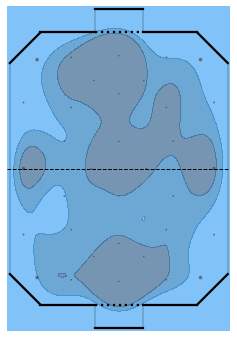

In [10]:
df_plt = flat_df.loc[:, ['is_orange','pos_x', 'pos_y', 'pos_z']].sample(2000)
fig = plt.figure(figsize=(4,6))
ax = fig.gca()
fig = sns.kdeplot(x='pos_x', y='pos_y',data=df_plt, fill=.5, shade_lowest=True, levels=4, label='blue', alpha=.7)
plot_rl_field_aesthetics(fig, ax) 
sns.despine(left=True, bottom=True)  
fig.set_ylabel('')
fig.set_yticks([])
fig.set_xlabel('')
fig.set_xticks([])
fig.set_xlim(-4196,4196)    
fig.set_ylim(-6100,6100) 
fig.set_aspect('equal')
fig.legend([]).set_visible(False) 
plt.show()


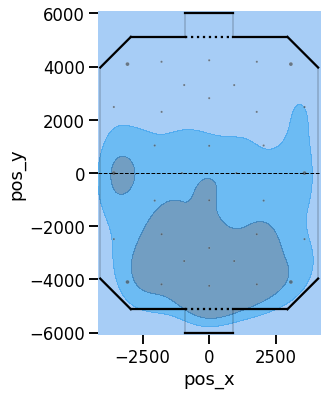

In [11]:
df_plt.loc[df_plt['is_orange']==1, ['pos_x', 'pos_y']] = df_plt.loc[df_plt['is_orange']==1, ['pos_x', 'pos_y']].mul(-1)

fig = plt.figure(figsize=(4,6))
ax = fig.gca()
fig = sns.kdeplot(x='pos_x', y='pos_y',data=df_plt, fill=.5, shade_lowest=True, levels=4, label='blue', alpha=.7)
plot_rl_field_aesthetics(fig, ax) 
sns.despine(left=True, bottom=True)  
# fig.set_ylabel('')
# fig.set_yticks([])
# fig.set_xlabel('')
# fig.set_xticks([])
fig.set_xlim(-4196,4196)    
fig.set_ylim(-6100,6100) 
fig.set_aspect('equal')
fig.legend([]).set_visible(False) 
plt.show()


x: 1100.0
y: 1800.0
z: 50.0


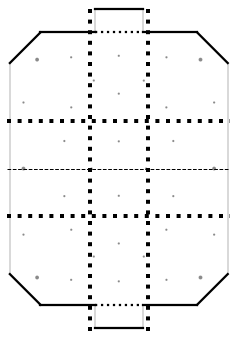

In [12]:
fig = plt.figure(figsize=(4,6))
ax = fig.gca()
fig = sns.scatterplot(x='pos_x', y='pos_y',data=one_goal.sample(1), alpha=0)
plot_rl_field_aesthetics(fig, ax) 
sns.despine(left=True, bottom=True)  
fig.set_ylabel('')
fig.set_yticks([])
fig.set_xlabel('')
fig.set_xticks([])
fig.set_xlim(-4196,4196)    
fig.set_ylim(-6100,6100) 

zone_markers = {}

for o in ['x', 'y', 'z']:
  marker = np.mean([abs(round(flat_df[f'pos_{o}'].quantile(.33), -2)), abs(round(flat_df[f'pos_{o}'].quantile(.66), -2))])
  print(f"{o}: {marker}")
  zone_markers[o] = marker
  if o == 'y':
    plt.axhline(marker, c='k', ls=':', lw=4)
    plt.axhline(-marker, c='k', ls=':', lw=4)
  elif o == 'z':
    continue
  else:
    plt.axvline(marker, c='k', ls=':', lw=4)
    plt.axvline(-marker, c='k', ls=':', lw=4)

fig.set_aspect('equal')
fig.legend([]).set_visible(False) 
plt.show()


## zone shit 

In [7]:
team_id = flat_df.loc[:, ['team', 'id']].drop_duplicates()
player_id = flat_df.loc[:, ['id', 'name']].drop_duplicates(subset=['id'])

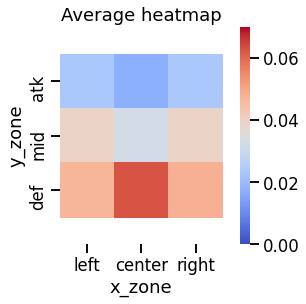

In [8]:
_df, lg_avg = _get_avg_heatmap(flat_df, 'xy')

limit = _df.max().max()
limit = limit * (1.05)
limit = round(limit, 2)

f = sns.heatmap(_df,vmin=0,vmax=limit,cmap='coolwarm',square=True)
b, t = f.get_ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
f.set_ylim(b, t) # update the ylim(bottom, top) values
plt.title(f"Average heatmap")
plt.show() 

In [101]:
lg_avg = make_lg_avg(flat_df)

In [103]:
player_zones = make_player_zones(flat_df)
player_zones['x_zone'] = player_zones['x_zone'].map({-1:'left',0:'center',1:'right'})
player_zones['y_zone'] = player_zones['y_zone'].map({1:'atk',0:'mid',-1:'def'})
player_zones['z_zone'] = player_zones['z_zone'].map({0:'floor',1:'air',2:'ceiling'})
player_zones = player_id.merge(player_zones)
player_zones = player_zones.loc[:, ['id', 'name', 'x_zone', 'y_zone', 'z_zone', 'pct']]
player_zones = player_zones.merge(lg_avg, on=['x_zone', 'y_zone', 'z_zone'], suffixes=('', '_lg_avg'))
player_zones['pct_aa'] = player_zones['pct'].sub(player_zones['pct_lg_avg'])

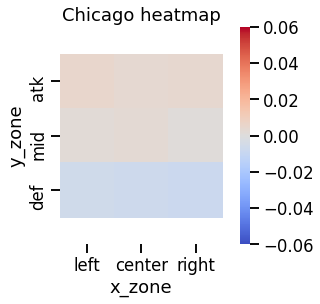

In [108]:
player_name = player_zones['name'].sample(1).values[0]
axis_1 = 'x'
axis_2 = 'y'
index = {-1:'atk',0:'mid',1:'def'}
columns = {-1:'left',0:'center',1:'right'}
df_stage = player_zones.loc[player_zones['name']==player_name]
_df = pd.pivot_table(df_stage.loc[:,[f'{axis_1}_zone',f'{axis_2}_zone','pct_aa']],
                  values=['pct_aa'],columns=f'{axis_1}_zone',index=f'{axis_2}_zone')
_df = _df['pct_aa'].loc[:, list(columns.values())]
_df = _df.loc[list(index.values())]

# 0.06 is hard coded based on the general min and max of pct_aa 
limit = 0.06
f = sns.heatmap(_df,vmin=-limit,vmax=limit,cmap='coolwarm',square=True)
b, t = f.get_ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
f.set_ylim(b, t) # update the ylim(bottom, top) values
plt.title(f"{player_name} heatmap")
plt.show() 

In [109]:
test = df_goals.loc[:, ['match_id', 'game_number', 'game_id', 'id', 'name', 'goal_frame_number_5s', 'goal_frame_number']].dropna()
test['range'] = [list(range(i, j+1)) for i, j in test.loc[:, ['goal_frame_number_5s', 'goal_frame_number']].astype(int).values]
test = test.explode('range').rename(columns={'range':'frames'})
test = test.merge(flat_df)
test = test.merge(df_ball
                  .loc[:, ['frames', 'match_date', 'match_id', 'game_number', 
                           'game_id', 'pos_x', 'pos_y', 'pos_z', 'vel_x', 
                           'vel_y', 'vel_z', 'ang_vel_x', 'ang_vel_y', 
                           'ang_vel_z', 'hit_team_no', 'rot_x', 'rot_y', 
                           'rot_z']], 
                  on=['frames', 'match_date', 'match_id', 
                      'game_number', 'game_id'], 
                  suffixes=('', '_ball'))
test['dist'] = np.sqrt((test['pos_x'] - test['pos_x_ball'])**2 + (test['pos_y'] - test['pos_y_ball'])**2 + (test['pos_z'] - test['pos_z_ball'])**2)
_test = test.loc[:, ['match_id', 'game_number', 'game_id', 'id', 'goal_frame_number', 'dist']].groupby(['match_id', 'game_number', 'game_id', 'id', 'goal_frame_number'], as_index=False).min()
ball_contact = _test.merge(test)
ball_contact['pos_x_plot'] = ball_contact['pos_x']
ball_contact['pos_y_plot'] = ball_contact['pos_y']
ball_contact.loc[ball_contact['is_orange']==True, 'pos_x_plot'] = ball_contact.loc[ball_contact['is_orange']==True,'pos_x_plot'].mul(-1)
ball_contact.loc[ball_contact['is_orange']==True, 'pos_y_plot'] = ball_contact.loc[ball_contact['is_orange']==True,'pos_y_plot'].mul(-1)

In [110]:
goal_lg_avg = make_lg_avg(ball_contact)
goal_zones = make_player_zones(ball_contact)
goal_zones['x_zone'] = goal_zones['x_zone'].map({-1:'left',0:'center',1:'right'})
goal_zones['y_zone'] = goal_zones['y_zone'].map({1:'atk',0:'mid',-1:'def'})
goal_zones['z_zone'] = goal_zones['z_zone'].map({0:'floor',1:'air',2:'ceiling'})
goal_zones = player_id.merge(goal_zones)
goal_zones = goal_zones.loc[:, ['id', 'name', 'x_zone', 'y_zone', 'z_zone', 'pct']]

a = goal_zones.loc[:, ['x_zone', 'y_zone', 'z_zone']].drop_duplicates()
a['one'] = 1
b = goal_zones.loc[:, ['name']].drop_duplicates()
b['one'] = 1
c = a.merge(b, on=['one'])

goal_zones=c.merge(goal_zones, how='left')
goal_zones['id'] = goal_zones['id'].fillna(method='pad')
goal_zones['pct'] = goal_zones['pct'].fillna(0)
goal_zones = goal_zones.merge(goal_lg_avg, on=['x_zone', 'y_zone', 'z_zone'], suffixes=('', '_lg_avg'))
goal_zones['pct_aa'] = goal_zones['pct'].sub(goal_zones['pct_lg_avg'])
goal_zones = goal_zones.drop('one', axis=1)

`shade_lowest` is now deprecated in favor of `thresh`. Setting `thresh=0`, but please update your code.


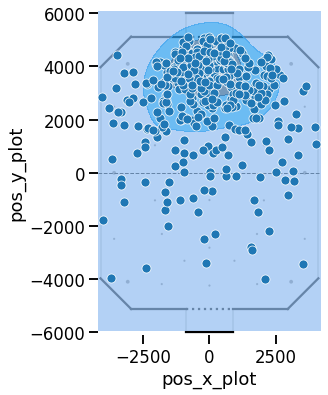

In [112]:
fig = plt.figure(figsize=(4,6))
ax = fig.gca()
fig = sns.kdeplot(x='pos_x_plot', y='pos_y_plot', data=ball_contact, fill=.5, shade_lowest=True, levels=4, label='blue', alpha=.7, zorder=5)
fig = sns.scatterplot(x='pos_x_plot', y='pos_y_plot', data=ball_contact, zorder=6)
plot_rl_field_aesthetics(fig, ax) 
sns.despine(left=True, bottom=True)  
fig.set_xlim(-4196,4196)    
fig.set_ylim(-6100,6100) 
fig.set_aspect('equal')
fig.legend([]).set_visible(False) 
plt.show()


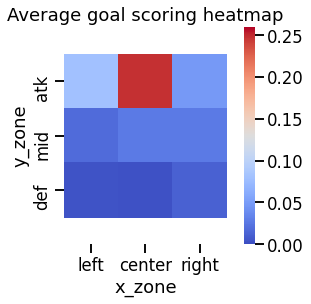

In [189]:
_df, lg_avg = _get_avg_heatmap(ball_contact, 'xy')

limit = _df.max().max()
limit = limit * (1.05)
limit = round(limit, 2)

f = sns.heatmap(_df,vmin=0,vmax=limit,cmap='coolwarm',square=True)
b, t = f.get_ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
f.set_ylim(b, t) # update the ylim(bottom, top) values 
plt.title(f"Average goal scoring heatmap") 
plt.show() 

In [190]:
# wtf
_df

x_zone,left,center,right
y_zone,,,
atk,0.080605,0.248111,0.048699
mid,0.018472,0.027708,0.027708
def,0.005038,0.003778,0.012594


(-0.04614969413458078, 0.05845839595283958)

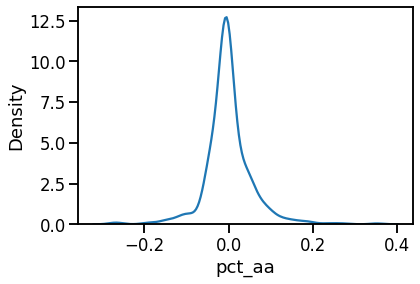

In [114]:
sns.kdeplot(goal_zones['pct_aa'])
goal_zones['pct_aa'].quantile(.1),goal_zones['pct_aa'].quantile(.9)


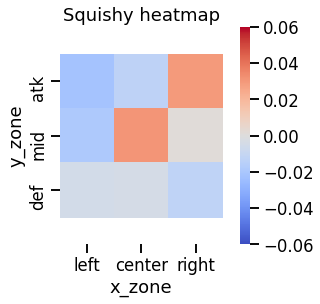

In [118]:
player_name = goal_zones['name'].sample(1).values[0]
axis_1 = 'x'
axis_2 = 'y'
index = {-1:'atk',0:'mid',1:'def'}
columns = {-1:'left',0:'center',1:'right'}
df_stage = goal_zones.loc[goal_zones['name']==player_name]
_df = pd.pivot_table(df_stage.loc[:,[f'{axis_1}_zone',f'{axis_2}_zone','pct_aa']],
                  values=['pct_aa'],columns=f'{axis_1}_zone',index=f'{axis_2}_zone')
_df = _df['pct_aa'].loc[:, list(columns.values())]
_df = _df.loc[list(index.values())]

# 0.06 is hard coded based on the general min and max of pct_aa 
limit = 0.06
f = sns.heatmap(_df,vmin=-limit,vmax=limit,cmap='coolwarm',square=True)
b, t = f.get_ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
f.set_ylim(b, t) # update the ylim(bottom, top) values
plt.title(f"{player_name} heatmap") 
plt.show() 

# entering zones 

In [119]:
test = ball_contact.loc[:, ['match_id', 'game_number', 'game_id', 'id', 'frames']].rename(columns={'frames':'goal_frame_number'}).copy()
test['goal_frame_number_2s'] = test['goal_frame_number'].sub(40)
test['range'] = [list(range(i, j+1)) for i, j in test.loc[:, ['goal_frame_number_2s', 'goal_frame_number']].astype(int).values]
test = test.explode('range').rename(columns={'range':'frames'})
zone_entrance = test.merge(flat_df)

In [121]:
setup_lg_avg = make_lg_avg(zone_entrance)
setup_zones = make_player_zones(zone_entrance)
setup_zones['x_zone'] = setup_zones['x_zone'].map({-1:'left',0:'center',1:'right'})
setup_zones['y_zone'] = setup_zones['y_zone'].map({1:'atk',0:'mid',-1:'def'})
setup_zones['z_zone'] = setup_zones['z_zone'].map({0:'floor',1:'air',2:'ceiling'})
setup_zones = player_id.merge(setup_zones)
setup_zones = setup_zones.loc[:, ['id', 'name', 'x_zone', 'y_zone', 'z_zone', 'pct']]

a = setup_zones.loc[:, ['x_zone', 'y_zone', 'z_zone']].drop_duplicates()
a['one'] = 1
b = setup_zones.loc[:, ['name']].drop_duplicates()
b['one'] = 1
c = a.merge(b, on=['one'])

setup_zones=c.merge(setup_zones, how='left')
setup_zones['id'] = setup_zones['id'].fillna(method='pad')
setup_zones['pct'] = setup_zones['pct'].fillna(0)
setup_zones = setup_zones.merge(goal_lg_avg, on=['x_zone', 'y_zone', 'z_zone'], suffixes=('', '_lg_avg'))
setup_zones['pct_aa'] = setup_zones['pct'].sub(setup_zones['pct_lg_avg'])
setup_zones = setup_zones.drop('one', axis=1)

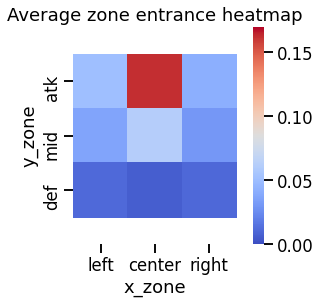

In [122]:
_df, lg_avg = _get_avg_heatmap(zone_entrance, 'xy')

limit = _df.max().max()
limit = limit * (1.05)
limit = round(limit, 2)

f = sns.heatmap(_df,vmin=0,vmax=limit,cmap='coolwarm',square=True)
b, t = f.get_ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
f.set_ylim(b, t) # update the ylim(bottom, top) values 
plt.title(f"Average zone entrance heatmap") 
plt.show() 

(-0.04534005037783375, 0.058271512973316134)

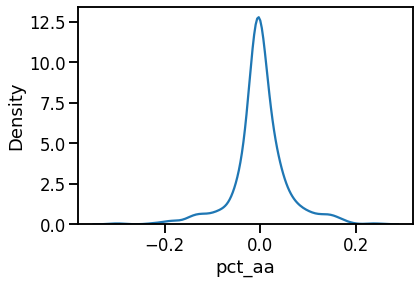

In [123]:
sns.kdeplot(setup_zones['pct_aa'])
setup_zones['pct_aa'].quantile(.1),setup_zones['pct_aa'].quantile(.9)


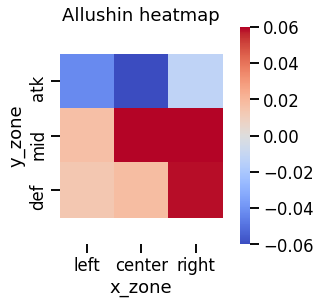

In [125]:
player_name = setup_zones['name'].sample(1).values[0]
axis_1 = 'x'
axis_2 = 'y'
index = {-1:'atk',0:'mid',1:'def'}
columns = {-1:'left',0:'center',1:'right'}
df_stage = setup_zones.loc[setup_zones['name']==player_name]
_df = pd.pivot_table(df_stage.loc[:,[f'{axis_1}_zone',f'{axis_2}_zone','pct_aa']],
                  values=['pct_aa'],columns=f'{axis_1}_zone',index=f'{axis_2}_zone')
_df = _df['pct_aa'].loc[:, list(columns.values())]
_df = _df.loc[list(index.values())]

# 0.06 is hard coded based on the general min and max of pct_aa 
limit = 0.06
f = sns.heatmap(_df,vmin=-limit,vmax=limit,cmap='coolwarm',square=True)
b, t = f.get_ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
f.set_ylim(b, t) # update the ylim(bottom, top) values
plt.title(f"{player_name} heatmap") 
plt.show() 

## run scouting reports here! 

In [22]:
def get_rl_scouting_report_data(flat_df, df_ball, df_goals):
  team_id = flat_df.loc[:, ['team', 'id']].drop_duplicates()
  player_id = flat_df.loc[:, ['id', 'name']].drop_duplicates(subset=['id'])

  test = df_goals.loc[:, ['match_id', 'game_number', 'game_id', 'id', 'name', 'goal_frame_number_5s', 'goal_frame_number']].dropna()
  test['range'] = [list(range(i, j+1)) for i, j in test.loc[:, ['goal_frame_number_5s', 'goal_frame_number']].astype(int).values]
  test = test.explode('range').rename(columns={'range':'frames'})
  test = test.merge(flat_df)
  test = test.merge(df_ball
                    .loc[:, ['frames', 'match_date', 'match_id', 'game_number', 
                            'game_id', 'pos_x', 'pos_y', 'pos_z', 'vel_x', 
                            'vel_y', 'vel_z', 'ang_vel_x', 'ang_vel_y', 
                            'ang_vel_z', 'hit_team_no', 'rot_x', 'rot_y', 
                            'rot_z']], 
                    on=['frames', 'match_date', 'match_id', 
                        'game_number', 'game_id'], 
                    suffixes=('', '_ball'))
  test['dist'] = np.sqrt((test['pos_x'] - test['pos_x_ball'])**2 + (test['pos_y'] - test['pos_y_ball'])**2 + (test['pos_z'] - test['pos_z_ball'])**2)
  _test = test.loc[:, ['match_id', 'game_number', 'game_id', 'id', 'goal_frame_number', 'dist']].groupby(['match_id', 'game_number', 'game_id', 'id', 'goal_frame_number'], as_index=False).min()
  ball_contact = _test.merge(test)
  ball_contact['pos_x_plot'] = ball_contact['pos_x']
  ball_contact['pos_y_plot'] = ball_contact['pos_y']
  ball_contact.loc[ball_contact['is_orange']==True, 'pos_x_plot'] = ball_contact.loc[ball_contact['is_orange']==True,'pos_x_plot'].mul(-1)
  ball_contact.loc[ball_contact['is_orange']==True, 'pos_y_plot'] = ball_contact.loc[ball_contact['is_orange']==True,'pos_y_plot'].mul(-1)

  goal_lg_avg = make_lg_avg(ball_contact)
  goal_zones = make_player_zones(ball_contact)
  goal_zones['x_zone'] = goal_zones['x_zone'].map({-1:'left',0:'center',1:'right'})
  goal_zones['y_zone'] = goal_zones['y_zone'].map({1:'atk',0:'mid',-1:'def'})
  goal_zones['z_zone'] = goal_zones['z_zone'].map({0:'floor',1:'air',2:'ceiling'})
  goal_zones = player_id.merge(goal_zones)
  goal_zones = goal_zones.loc[:, ['id', 'name', 'x_zone', 'y_zone', 'z_zone', 'pct']]

  a = goal_zones.loc[:, ['x_zone', 'y_zone', 'z_zone']].drop_duplicates()
  a['one'] = 1
  b = goal_zones.loc[:, ['name']].drop_duplicates()
  b['one'] = 1
  c = a.merge(b, on=['one'])

  goal_zones=c.merge(goal_zones, how='left')
  goal_zones['id'] = goal_zones['id'].fillna(method='pad')
  goal_zones['pct'] = goal_zones['pct'].fillna(0)
  goal_zones = goal_zones.merge(goal_lg_avg, on=['x_zone', 'y_zone', 'z_zone'], suffixes=('', '_lg_avg'))
  goal_zones['pct_aa'] = goal_zones['pct'].sub(goal_zones['pct_lg_avg'])
  goal_zones = goal_zones.drop('one', axis=1)

  test = ball_contact.loc[:, ['match_id', 'game_number', 'game_id', 'id', 'frames']].rename(columns={'frames':'goal_frame_number'}).copy()
  test['goal_frame_number_2s'] = test['goal_frame_number'].sub(40)
  test['range'] = [list(range(i, j+1)) for i, j in test.loc[:, ['goal_frame_number_2s', 'goal_frame_number']].astype(int).values]
  test = test.explode('range').rename(columns={'range':'frames'})
  zone_entrance = test.merge(flat_df)

  setup_lg_avg = make_lg_avg(zone_entrance)
  setup_zones = make_player_zones(zone_entrance)
  setup_zones['x_zone'] = setup_zones['x_zone'].map({-1:'left',0:'center',1:'right'})
  setup_zones['y_zone'] = setup_zones['y_zone'].map({1:'atk',0:'mid',-1:'def'})
  setup_zones['z_zone'] = setup_zones['z_zone'].map({0:'floor',1:'air',2:'ceiling'})
  setup_zones = player_id.merge(setup_zones)
  setup_zones = setup_zones.loc[:, ['id', 'name', 'x_zone', 'y_zone', 'z_zone', 'pct']]

  a = setup_zones.loc[:, ['x_zone', 'y_zone', 'z_zone']].drop_duplicates()
  a['one'] = 1
  b = setup_zones.loc[:, ['name']].drop_duplicates()
  b['one'] = 1
  c = a.merge(b, on=['one'])

  setup_zones=c.merge(setup_zones, how='left')
  setup_zones['id'] = setup_zones['id'].fillna(method='pad')
  setup_zones['pct'] = setup_zones['pct'].fillna(0)
  setup_zones = setup_zones.merge(goal_lg_avg, on=['x_zone', 'y_zone', 'z_zone'], suffixes=('', '_lg_avg'))
  setup_zones['pct_aa'] = setup_zones['pct'].sub(setup_zones['pct_lg_avg'])
  setup_zones = setup_zones.drop('one', axis=1)

  player_goals = df_goals.loc[:, ['id', 'is_goal']].groupby(['id'], as_index=False).sum() 

  stat_sheet = team_id.merge(player_goals, how='left').fillna(0).merge(player_id).rename(columns={'is_goal':'goals'})
  test = flat_df.merge(df_ball
                    .loc[:, ['frames', 'match_date', 'match_id', 'game_number', 
                            'game_id', 'pos_x', 'pos_y', 'pos_z', 'vel_x', 
                            'vel_y', 'vel_z', 'ang_vel_x', 'ang_vel_y', 
                            'ang_vel_z', 'hit_team_no', 'rot_x', 'rot_y', 
                            'rot_z']], 
                    on=['frames', 'match_date', 'match_id', 
                        'game_number', 'game_id'], 
                    suffixes=('', '_ball'))
  test['dist'] = np.sqrt((test['pos_x'] - test['pos_x_ball'])**2 + (test['pos_y'] - test['pos_y_ball'])**2 + (test['pos_z'] - test['pos_z_ball'])**2)
  all_ball_contact = test.loc[test['dist']<300]
  all_ball_contact['pos_x_plot'] = all_ball_contact['pos_x']
  all_ball_contact['pos_y_plot'] = all_ball_contact['pos_y']
  all_ball_contact.loc[all_ball_contact['is_orange']==True, 'pos_x_plot'] = all_ball_contact.loc[all_ball_contact['is_orange']==True,'pos_x_plot'].mul(-1)
  all_ball_contact.loc[all_ball_contact['is_orange']==True, 'pos_y_plot'] = all_ball_contact.loc[all_ball_contact['is_orange']==True,'pos_y_plot'].mul(-1)

  all_ball_contact['frames_shift'] = all_ball_contact['frames'].shift(-1)
  all_ball_contact['frames_diff'] = all_ball_contact['frames_shift'].sub(all_ball_contact['frames'])

  all_ball_contact = all_ball_contact.loc[(all_ball_contact['frames_diff']>1)]

  ball_touches = all_ball_contact.loc[:, ['game_id', 'match_id', 'id', 'team', 'frames']].groupby(['game_id', 'match_id', 'id', 'team'], as_index=False).count().rename(columns={'frames':'ball_touches'})
  _ball_touches = ball_touches.loc[:, ['id', 'team', 'ball_touches']].groupby(['id', 'team'], as_index=False).sum().rename(columns={'frames':'total_ball_touches'})
  ball_touches = player_id.merge(_ball_touches).merge(ball_touches.loc[:, ['id', 'team', 'ball_touches']].rename(columns={'ball_touches':'ball_touch_per_game'}).groupby(['id', 'team'], as_index=False).mean())

  stat_sheet = stat_sheet.merge(ball_touches)
  stat_sheet['goals_per_touch'] = stat_sheet['goals'].div(stat_sheet['ball_touches'])
  stat_sheet['ball_touch_per_game_aa'] = stat_sheet['ball_touch_per_game'].sub(stat_sheet['ball_touch_per_game'].mean())
  stat_sheet['goals_per_touch_aa'] = stat_sheet['goals_per_touch'].sub(stat_sheet['goals_per_touch'].mean())

  return goal_zones, setup_zones, stat_sheet

def rl_team_report(team_name, goal_zones, setup_zones, stat_sheet):
  players = stat_sheet.loc[stat_sheet['team']==team_name, 'name'].unique()

  for player_name in players:
    axis_1 = 'x'
    axis_2 = 'y'
    index = {-1:'atk',0:'mid',1:'def'}
    columns = {-1:'left',0:'center',1:'right'}

    _stat_print = stat_sheet.loc[stat_sheet['name']==player_name, 
                                ['team', 'name', 'goals','ball_touches',
                                'ball_touch_per_game', 'goals_per_touch', 
                                'goals_per_touch_aa']]

    stat_cols = ['goals', 'ball_touches', 'ball_touch_per_game', 
                'goals_per_touch', 'goals_per_touch_aa']                              

    df_stage = goal_zones.loc[goal_zones['name']==player_name]
    _df = pd.pivot_table(df_stage.loc[:,[f'{axis_1}_zone',f'{axis_2}_zone','pct_aa']],
                      values=['pct_aa'],columns=f'{axis_1}_zone',index=f'{axis_2}_zone')
    _df = _df['pct_aa'].loc[:, list(columns.values())]
    gs_df = _df.loc[list(index.values())]

    df_stage = setup_zones.loc[setup_zones['name']==player_name]
    _df = pd.pivot_table(df_stage.loc[:,[f'{axis_1}_zone',f'{axis_2}_zone','pct_aa']],
                      values=['pct_aa'],columns=f'{axis_1}_zone',index=f'{axis_2}_zone')
    _df = _df['pct_aa'].loc[:, list(columns.values())]
    _df = _df.loc[list(index.values())]

    select_zones = pd.DataFrame([[1,2,3],[4,5,6],[7,8,9]],index=_df.index, columns=_df.columns) 
    smol = select_zones[(_df>.02) & (_df<=.04)].values 
    smol = smol[np.logical_not(np.isnan(smol))] 

    lorg = select_zones[_df>.04].values 
    lorg = lorg[np.logical_not(np.isnan(lorg))] 

    # 0.06 is hard coded based on the general min and max of pct_aa 
    limit = 0.06
    f = sns.heatmap(gs_df,vmin=-limit,vmax=limit,cmap='coolwarm',square=True)
    # plt.axvline(2, c='k', ls='-', lw=3)

    for x in smol:
      draw_setup_square(x, 3)

    for x in lorg:
      draw_setup_square(x, 5)  

    b, t = f.get_ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    f.set_ylim(b, t) # update the ylim(bottom, top) values
    plt.title(f"Scoring heatmap") 

    plt.text(6, 0, f"""[{_stat_print['team'].values[0]}] {_stat_print['name'].values[0]}""", size=24, va='top')
    stats_str = ''
    for col in stat_cols:
      if col in ['ball_touch_per_game', 'goals_per_touch', 'goals_per_touch_aa']:
        stats_str = f"""{stats_str}\n{col}: {round(_stat_print[col].values[0], 3)}"""
      else:
        stats_str = f"""{stats_str}\n{col}: {_stat_print[col].values[0]}"""

    plt.text(6, 0.5, stats_str, size=14, va='top')
    plt.show()   

In [11]:
train_flat_df = flat_df.loc[flat_df['week']!=44]
train_df_ball = df_ball.loc[df_ball['week']!=44] 
train_df_goals = df_goals.loc[df_goals['week']!=44] 
test_flat_df = flat_df.loc[flat_df['week']==44]
test_df_ball = df_ball.loc[df_ball['week']==44] 
test_df_goals = df_goals.loc[df_goals['week']==44] 

In [24]:
goal_zones, setup_zones, stat_sheet = get_rl_scouting_report_data(train_flat_df, train_df_ball, train_df_goals)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

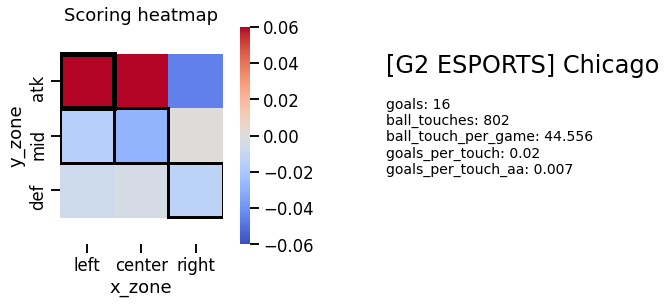

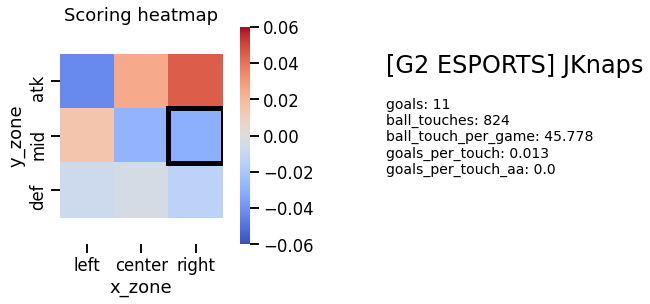

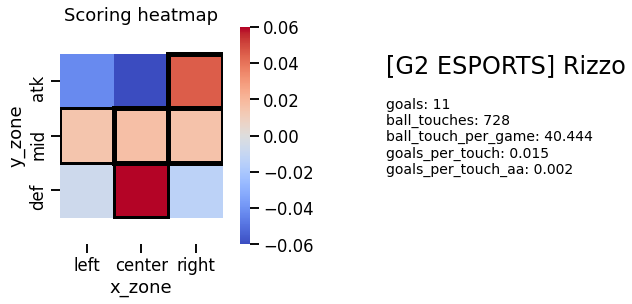

In [18]:
team_name = stat_sheet['team'].sample(1).values[0]
rl_team_report(team_name, goal_zones, setup_zones, stat_sheet)

you can type regular like in a word processor  
**you can bold**  
_you can italicize_  
_**you can do both**_  

* you can make bullets  
* just like this  

# you can make headings 
## and make them smaller if you want
#### real small if you want  

$\text{you can also do } \LaTeX $  
$$ \text{you can also have latex blocks} $$  

you | can | make | tables  
--- | --- | --- | ---  
like | this | lol | !!!  

```r 
you can code in other languanges
library(lol) 
cool <- nickwan  
```

artifact by silentstorm11699

# make the audit


In [23]:
goal_zones_audit, setup_zones_audit, stat_sheet_audit = get_rl_scouting_report_data(test_flat_df, test_df_ball, test_df_goals)


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

advance report


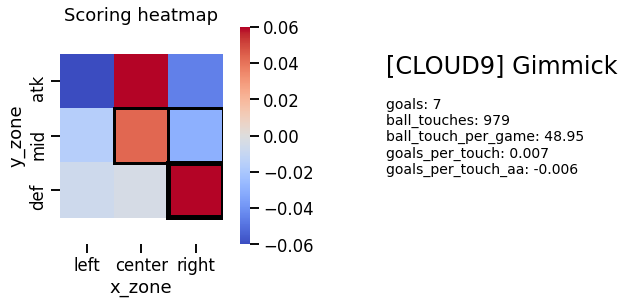

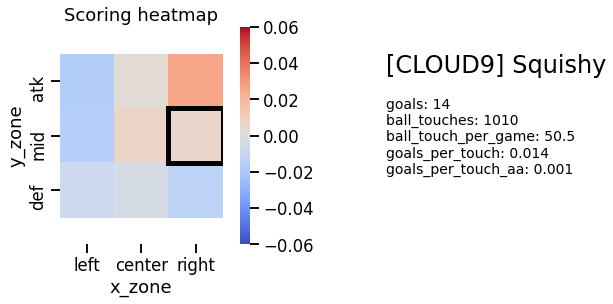

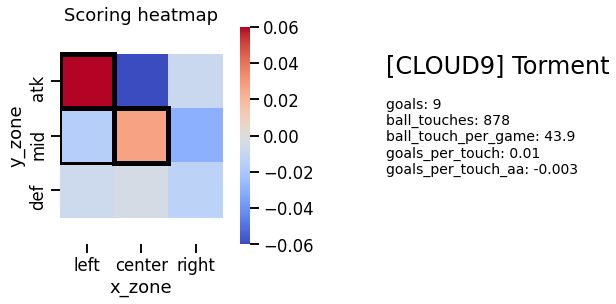

actual events


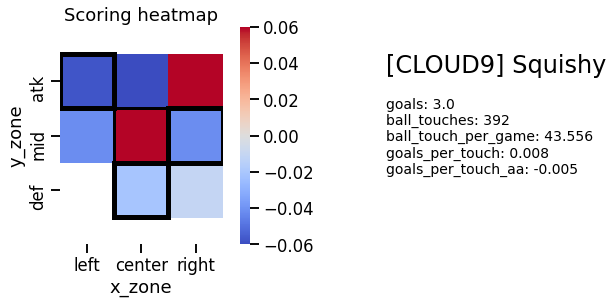

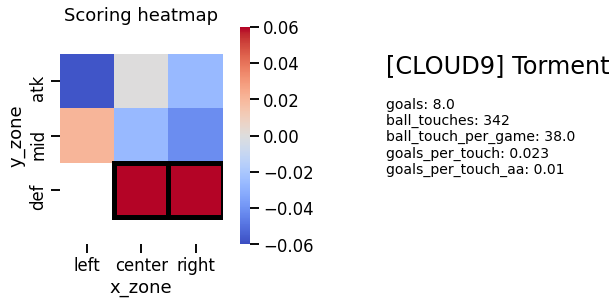

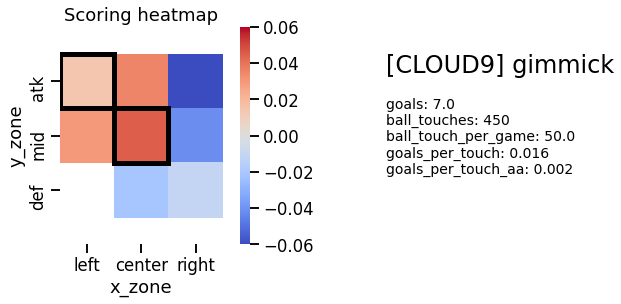

In [38]:
team_name = stat_sheet['team'].sample(1).values[0]
print('advance report')
rl_team_report(team_name, goal_zones, setup_zones, stat_sheet)

print('actual events')
rl_team_report(team_name, goal_zones_audit, setup_zones_audit, stat_sheet_audit)

# was this good?  
i think this is a pretty good first attempt, all things considered. behavior in terms of setup zones and goal scoring areas have pretty strong priors. it's still missing a lot (no indication of pass vs dribble vs first touch) and can absolutely be improved on with some simple modeling (xG, match up simulation, etc) but assuming no other teams are using some sort of quantitative method to help direct either vod review or defensive installation (if that's even a fucking thing) this small example is a fairly strong report.  

it would be very intriguing to understand how this information would get used. currently my thoughts suggest this information could help with more specific marking (i.e. car vs ball marking through particular zones) or perhaps rotation theory (when to play back hard vs when to play back soft, etc). it's also likely this information doesn't allow for either of those things and maybe is a better indicator for simply what to look for in vods (i.e. hot zone opportunities and why they happen).  

a few outstanding things from this dive: 

- skill vs talent. unsure whether certain behaviors are based on skill (i.e. something learned and can be improved on) versus talent (i.e. something that cannot be improved and your ability is innate in some way). for example, there seems to be a pattern of playing from the defensive-right through mid into attacking-left. is this a skill or is this a talent? do some players play this path with high goal scoring/assists whereas others try to do the same behavior but do not achieve goals/assists? is there actually a bias of goals from the attack-left versus attack-right? is this exploitable somehow? can this benefit player acquisition?   

- data fidelity. it's possible the look we are getting from these reports are still too basic. the advancements of coaching in pro RL could be far more forward-thinking than i previously thought, and this information is less actionable because coaches/players are already doing this through vod review in some optimized way. this would mean creating better explainable interactions that can help on a more micro-level of game play or emphasizing simulation and expected outcomes. either way, a rocket league analyst should probably focus on these things because some silly willy like me is doing this shit in my spare time with nothing to lose. so someone with a little more skin in the game could probably blow me out of the water (if players/coaches haven't already done that)  

overall, i think next time we come back to rocket league analytics we should either try to train our current heatmaps to predict match ups (with the output being a predictive/simulated heat map for advance scouting purposes) or we should try to dive even deeper and create a more comprehensive xG.  

-nw 1/22/2020